# Decoding Cardiac Patterns: Machine Learning Approaches to MIT-BIH Arrhythmia Classification

### Importing Required Packages

In [ ]:
import wfdb
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, welch, butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install xgboost tabulate scikit-learn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

### Loading Data

In [ ]:
# Define the data directory and rhythm dictionary for demonstration purposes
data_directory = r'C:\Users\likhi\OneDrive\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0'

# Rhythm dictionary for demonstration
rhythm_dict = {
    '100': [('N', '30:06')],
    '101': [('N', '30:06')],
    '102': [('N', '1:22'), ('P', '28:44')],
    '103': [('N', '30:06')],
    '104': [('N', '3:52'), ('P', '26:13')],
    '105': [('N', '30:06')],
    '106': [('N', '22:36'), ('B', '7:15'), ('T', '0:13'), ('VT', '0:02')],
    '107': [('P', '30:06')],
    '108': [('N', '30:06')],
    '109': [('N', '30:06')],
    '111': [('N', '30:06')],
    '112': [('N', '30:06')],
    '113': [('N', '30:06')],
    '114': [('N', '30:01'), ('SVTA', '0:05')],
    '115': [('N', '30:06')],
    '116': [('N', '30:06')],
    '117': [('N', '30:06')],
    '118': [('N', '30:06')],
    '119': [('N', '22:36'), ('B', '3:55'), ('T', '3:34')],
    '121': [('N', '30:06')],
    '122': [('N', '30:06')],
    '123': [('N', '30:06')],
    '124': [('N', '28:36'), ('NOD', '0:30'), ('T', '0:22'), ('IVR', '0:37')],
    '200': [('N', '15:58'), ('B', '13:52'), ('VT', '0:15')],
    '201': [('N', '12:57'), ('SVTA', '0:02'), ('AFIB', '10:06'), ('NOD', '0:24'), ('T', '6:37')],
    '202': [('N', '19:31'), ('AFL', '0:48'), ('AFIB', '9:46')],
    '203': [('N', '2:43'), ('AFL', '5:14'), ('AFIB', '21:32'), ('T', '0:04'), ('VT', '0:33')],
    '205': [('N', '29:43'), ('VT', '0:23')],
    '207': [('N', '22:20'), ('SVTA', '0:52'), ('B', '2:38'), ('IVR', '1:49'), ('VT', '0:03'), ('VFL', '2:24')],
    '208': [('N', '24:43'), ('T', '5:22')],
    '209': [('N', '28:23'), ('SVTA', '1:42')],
    '210': [('AFIB', '29:30'), ('B', '0:23'), ('T', '0:07'), ('VT', '0:06')],
    '212': [('N', '30:06')],
    '213': [('N', '29:01'), ('B', '1:00'), ('VT', '0:04')],
    '214': [('N', '28:53'), ('T', '1:08'), ('VT', '0:05')],
    '215': [('N', '30:03'), ('VT', '0:02')],
    '217': [('AFIB', '4:12'), ('P', '25:10'), ('B', '0:42'), ('VT', '0:02')],
    '219': [('N', '6:01'), ('AFIB', '23:47'), ('B', '0:08'), ('T', '0:10')],
    '220': [('N', '29:50'), ('SVTA', '0:16')],
    '221': [('AFIB', '29:17'), ('B', '0:03'), ('T', '0:42'), ('VT', '0:04')],
    '222': [('N', '15:57'), ('AB', '1:28'), ('SVTA', '0:08'), ('AFL', '7:03'), ('AFIB', '1:44'), ('NOD', '3:45')],
    '223': [('N', '23:23'), ('B', '4:19'), ('T', '0:38'), ('VT', '1:46')],
    '228': [('N', '24:17'), ('B', '5:48')],
    '230': [('N', '17:45'), ('PREX', '12:21')],
    '231': [('N', '18:26'), ('BII', '11:40')],
    '232': [('SBR', '30:06')],
    '233': [('N', '28:03'), ('B', '1:48'), ('T', '0:04'), ('VT', '0:11')],
    '234': [('N', '29:40'), ('SVTA', '0:26')]
}

### Signal Processing with Bandpass Filtering

In [ ]:
# Define a bandpass filter to remove noise
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

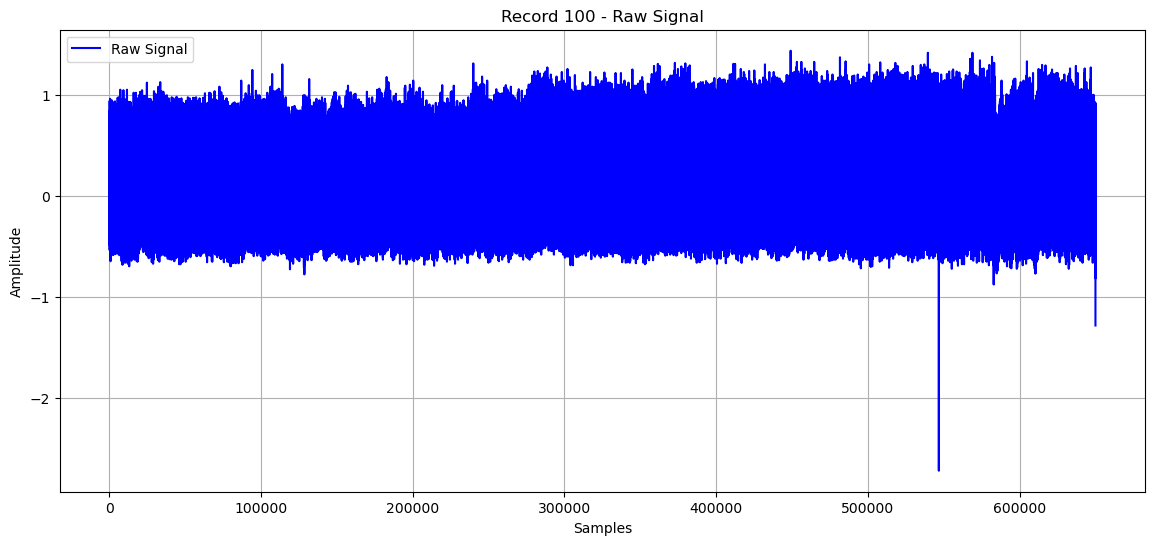

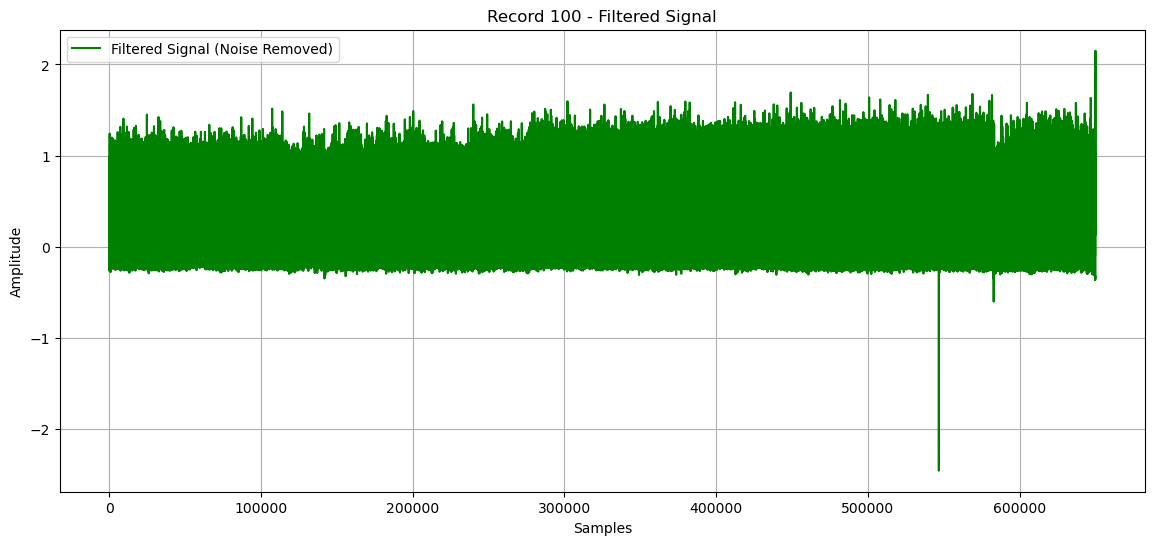

In [94]:
# Function to plot signals before and after filtering for a specific record
def plot_filtered_signal_separate(record_id, data_directory, sampling_rate=360):
    record_path = os.path.join(data_directory, record_id)
    ecg_record = wfdb.rdrecord(record_path)
    raw_signal = ecg_record.p_signal[:, 0]
    
    # Filter the signal
    filtered_signal = bandpass_filter(raw_signal, lowcut=0.5, highcut=40, fs=sampling_rate, order=4)
    
    # Create a new figure for the raw signal
    plt.figure(figsize=(14, 6))
    plt.plot(raw_signal, color='blue', label='Raw Signal')
    plt.title(f"Record {record_id} - Raw Signal")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Create a new figure for the filtered signal
    plt.figure(figsize=(14, 6))
    plt.plot(filtered_signal, color='green', label='Filtered Signal (Noise Removed)')
    plt.title(f"Record {record_id} - Filtered Signal")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()


selected_record_id = list(rhythm_dict.keys())[0]  
plot_filtered_signal_separate(selected_record_id, data_directory)


In [ ]:
def apply_sliding_window(signal_data, win_size, overlap_ratio):
    step_size = int(win_size * (1 - overlap_ratio))  # Calculate step size
    return np.lib.stride_tricks.sliding_window_view(signal_data, window_shape=win_size)[::step_size]

# Function to convert time strings to seconds
def time_to_seconds(time_str):
    if pd.isna(time_str) or time_str == '-':
        return 0
    mins, secs = map(int, time_str.split(':'))
    return mins * 60 + secs

# Parse the rhythm dictionary into a start and end time mapping
def map_rhythm_intervals(rhythm_dict):
    parsed_rhythms = {}
    for record, intervals in rhythm_dict.items():
        parsed_rhythms[record] = []
        curr_time = 0
        for rhythm, duration in intervals:
            duration_secs = time_to_seconds(duration)
            interval_end = curr_time + duration_secs
            parsed_rhythms[record].append((curr_time, interval_end, rhythm))
            curr_time = interval_end
    return parsed_rhythms

parsed_rhythm_map = map_rhythm_intervals(rhythm_dict)

# Function to get the rhythm label for a given window
def assign_rhythm_label(record_id, start, end, rhythm_map):
    if record_id not in rhythm_map:
        return None
    
    for start_time, end_time, label in rhythm_map[record_id]:
        # Adjust condition to allow for partial overlap
        if start < end_time and end > start_time:
            return label
    
    return None

In [ ]:
# Function to perform Z-score normalization
def normalize_z_score(data):
    data_mean = np.mean(data)
    data_std = np.std(data)
    return (data - data_mean) / data_std if data_std > 0 else data

In [ ]:
# Main function to calculate features and assign labels
def extract_features_for_records(record_ids, data_directory, win_size, overlap_ratio, rhythm_map, sampling_rate=360):
    extracted_features = []
    
    for record_id in record_ids:
        print(f"Processing record: {record_id}")
        record_path = os.path.join(data_directory, record_id)
        ecg_record = wfdb.rdrecord(record_path)
        raw_signal = ecg_record.p_signal[:, 0]
        
        # Filter the signal before extracting features
        filtered_signal = bandpass_filter(raw_signal, lowcut=0.5, highcut=40, fs=sampling_rate, order=4)
        
        ecg_segments = apply_sliding_window(filtered_signal, win_size, overlap_ratio)
        
        for i, segment in enumerate(ecg_segments):
            window_start = i * int(win_size * (1 - overlap_ratio)) / sampling_rate
            window_end = window_start + win_size / sampling_rate
            
            # Get the rhythm label from the rhythm_map
            rhythm_label = assign_rhythm_label(record_id, window_start, window_end, rhythm_map)
            
            normalized_segment = normalize_z_score(segment)
            
            # Calculate basic features from the normalized segment
            min_val = np.min(normalized_segment)
            max_val = np.max(normalized_segment)
            std_dev = np.std(normalized_segment)
            mean_val = np.mean(normalized_segment)
            median_val = np.median(normalized_segment)
            skewness_val = skew(normalized_segment)
            kurtosis_val = kurtosis(normalized_segment)

            # Find local maxima (R-peaks) and minima
            peaks, _ = find_peaks(normalized_segment, distance=sampling_rate//2)
            valleys, _ = find_peaks(-normalized_segment, distance=sampling_rate//2)

            # Calculate average local maxima and minima
            avg_peak = np.mean(normalized_segment[peaks]) if peaks.size > 0 else np.nan
            avg_valley = np.mean(normalized_segment[valleys]) if valleys.size > 0 else np.nan

            # Calculate amplitude as the difference between max and min
            if peaks.size > 0 and valleys.size > 0:
                amplitude = np.max(normalized_segment[peaks]) - np.min(normalized_segment[valleys])
            else:
                amplitude = np.nan  # If no peaks are found

            # Heart rate based on R-peaks
            r_peak_count = len(peaks)
            heart_rate = (r_peak_count / (win_size / sampling_rate)) * 60

            # RR intervals
            rr_intervals = np.diff(peaks) / sampling_rate if len(peaks) > 1 else [np.nan]
            avg_rr = np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan

            # Frequency-domain features using Welch's method
            freqs, power_spectral_density = welch(normalized_segment, sampling_rate)
            peak_freq = freqs[np.argmax(power_spectral_density)]  # Frequency with the highest power
            avg_power_density = np.mean(power_spectral_density)  # Average power spectral density
            
            extracted_features.append([
                record_id, min_val, max_val, std_dev, mean_val, median_val, skewness_val, kurtosis_val,
                avg_peak, avg_valley, amplitude,
                heart_rate, avg_rr, peak_freq, avg_power_density, rhythm_label
            ])

    return pd.DataFrame(extracted_features, columns=[
        "Record", "Minimum", "Maximum", "Standard_Deviation", "Mean", "Median", "Skewness", "Kurtosis",
        "Avg_Peak", "Avg_Valley", "Amplitude", "HeartRate", "Avg_RR_Interval",
        "Peak_Frequency", "Avg_Power_Spectral_Density", "Label"
    ])

# Calculate features with the updated rhythm mapping
feature_dataframe = extract_features_for_records(list(rhythm_dict.keys()), data_directory, win_size=360, overlap_ratio=0.5, rhythm_map=parsed_rhythm_map)





### Understanding ECG Data Metrics

### Dataset Overview And Preprocessing

In [95]:
feature_dataframe.head()

,Minimum,Maximum,Median,Skewness,Kurtosis,Avg_Peak,Avg_Valley,Amplitude,HeartRate,Avg_RR_Interval,Peak_Frequency,Avg_Power_Spectral_Density,Label
0,-1.824008,7.434238,0.007341,4.548722,28.048619,4.163973,-0.959397,9.258246,120.0,0.644444,5.62500,0.008314,6
1,-1.209420,7.427447,-0.076292,5.273549,31.763370,7.427447,-1.209420,8.636867,60.0,0.644444,5.62500,0.005344,6
2,-1.111960,5.604865,-0.211875,3.984114,16.596939,5.473948,-0.961328,6.716825,120.0,0.811111,1.40625,0.000603,6
3,-1.562353,7.834253,-0.128077,5.491076,35.829137,4.166451,-0.901496,9.396606,120.0,0.652778,7.03125,0.018906,6
4,-1.863916,7.714972,-0.153419,5.278437,34.204335,3.694793,-1.207813,9.578888,120.0,0.577778,4.21875,0.000681,6


In [37]:
feature_dataframe.tail()

,Minimum,Maximum,Median,Skewness,Kurtosis,Avg_Peak,Avg_Valley,Amplitude,HeartRate,Avg_RR_Interval,Peak_Frequency,Avg_Power_Spectral_Density,Label
173275,-0.747521,7.132307,-0.159240,5.228009,29.787041,3.853431,-0.747521,7.879828,120.0,0.566667,7.03125,0.018535,SVTA
173276,-0.796116,7.201555,-0.148205,5.277175,30.452824,3.421509,-0.714753,7.997671,120.0,0.525000,7.03125,0.001538,SVTA
173277,-0.592311,5.144464,-0.215925,3.775308,13.970910,5.064866,-0.580426,5.736775,120.0,0.677778,1.40625,0.000456,SVTA
173278,-0.699256,5.162912,-0.224651,3.677554,13.610398,5.054031,-0.596933,5.862168,120.0,0.655556,4.21875,0.007885,SVTA
173279,-0.632499,7.353512,-0.183099,5.590522,33.197676,3.671767,-0.632499,7.986011,120.0,0.541667,8.43750,0.015970,SVTA


In [38]:
# Display the shape of the DataFrame
print("Shape of the DataFrame:", feature_dataframe.shape)


Shape of the DataFrame: (173280, 13)


In [39]:
# Display data types of each column
print("Data Types:\n", feature_dataframe.dtypes)


Data Types:
 Minimum                        float64
Maximum                        float64
Median                         float64
Skewness                       float64
Kurtosis                       float64
Avg_Peak                       float64
Avg_Valley                     float64
Amplitude                      float64
HeartRate                      float64
Avg_RR_Interval                float64
Peak_Frequency                 float64
Avg_Power_Spectral_Density     float64
Label                         category
dtype: object


In [40]:
# Display unique values in each column
for column in feature_dataframe.select_dtypes(include=['object']).columns:
    print(f"Unique values in {column}:\n", feature_dataframe[column].unique())


In [41]:
# Check for duplicate rows
duplicates = feature_dataframe.duplicated().sum()
print("Number of duplicate rows:", duplicates)


Number of duplicate rows: 0


In [42]:
# Count unique classes and their counts
class_counts = feature_dataframe['Label'].value_counts()
print("\nClass counts:")
print(class_counts)


Class counts:
Label
N       126970
AFIB     15588
P        13222
B         5022
SBR       3610
T         2278
AFL       1570
PREX      1480
BII       1398
NOD        558
SVTA       416
VT         414
IVR        292
VFL        286
AB         176
Name: count, dtype: int64


In [43]:
# Check for missing values
missing_values = feature_dataframe.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Check if there are any missing values
if missing_values.any():
    print("\nMissing values found. Proceeding with imputation...")

    # Impute missing values using forward fill
    feature_dataframe.fillna(method='ffill', inplace=True)

    # Confirm that there are no missing values left
    missing_values_after_imputation = feature_dataframe.isnull().sum()
    print("\nMissing Values After Imputation:\n", missing_values_after_imputation)
else:
    print("\nNo missing values found.")


Missing Values in Each Column:
 Minimum                       0
Maximum                       0
Median                        0
Skewness                      0
Kurtosis                      0
Avg_Peak                      0
Avg_Valley                    0
Amplitude                     0
HeartRate                     0
Avg_RR_Interval               0
Peak_Frequency                0
Avg_Power_Spectral_Density    0
Label                         0
dtype: int64

No missing values found.


In [44]:
# Remove 'Record', 'Mean', and 'Standard_Deviation' columns
columns_to_remove = ['Record', 'Mean', 'Standard_Deviation']
feature_dataframe.drop(columns=[col for col in columns_to_remove if col in feature_dataframe.columns], inplace=True)
print(f"\nColumns removed: {', '.join(columns_to_remove)}")

# Convert 'Label' column from object to category
if 'Label' in feature_dataframe.columns:
    feature_dataframe['Label'] = feature_dataframe['Label'].astype('category')
    print("\n'Label' column converted to categorical data type.")



Columns removed: Record, Mean, Standard_Deviation

'Label' column converted to categorical data type.


In [61]:
# Dimensions and Data Types
print("Shape of DataFrame:", feature_dataframe.shape)
print("Data Types:\n", feature_dataframe.dtypes)

Shape of DataFrame: (173280, 13)
Data Types:
 Minimum                        float64
Maximum                        float64
Median                         float64
Skewness                       float64
Kurtosis                       float64
Avg_Peak                       float64
Avg_Valley                     float64
Amplitude                      float64
HeartRate                      float64
Avg_RR_Interval                float64
Peak_Frequency                 float64
Avg_Power_Spectral_Density     float64
Label                         category
dtype: object


### Visualizing ECG Sliding Windows

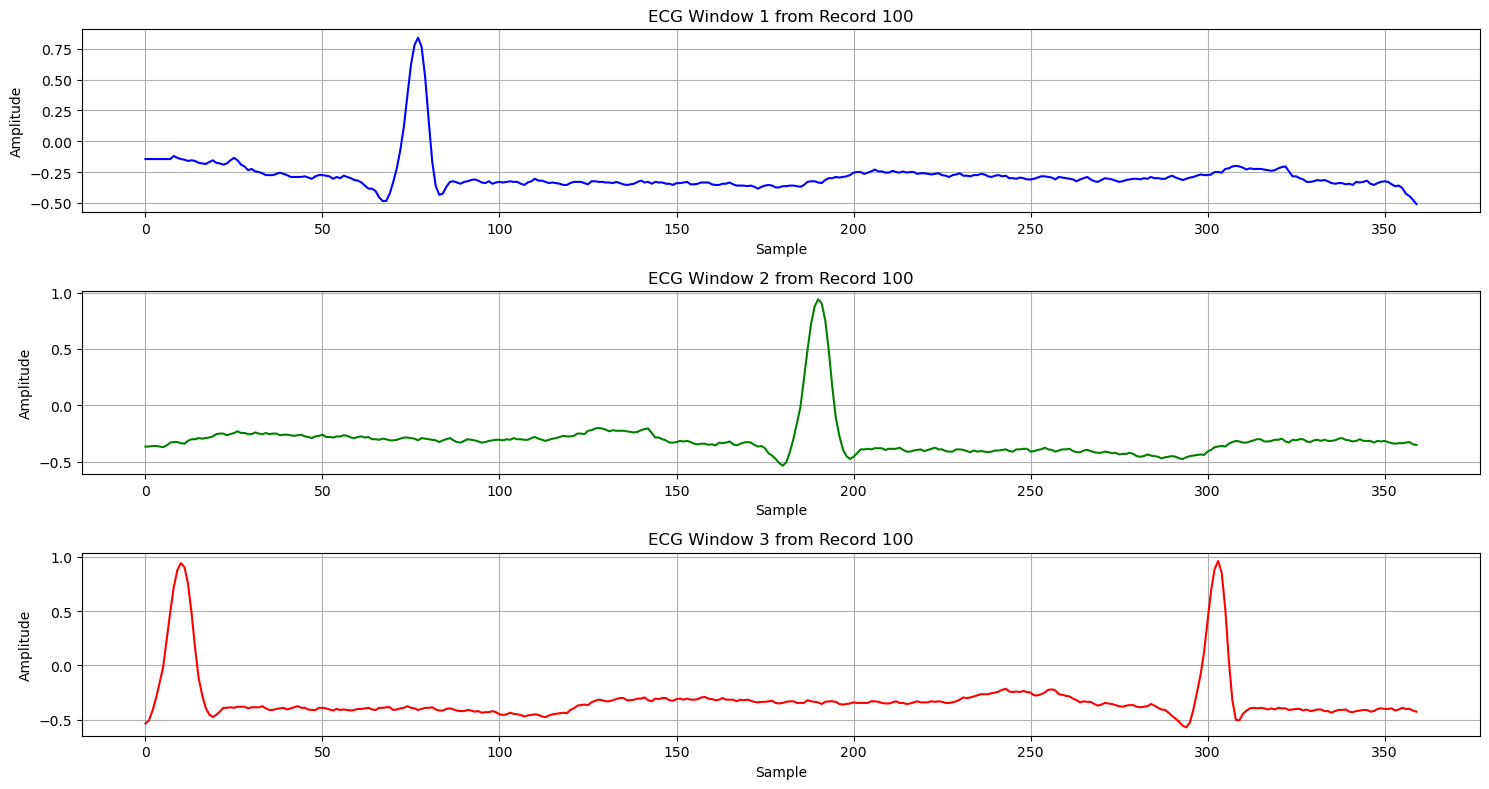

In [96]:
def visualize_ecg_windows(record_id, ecg_segments, num_windows=3):
    
    selected_windows = ecg_segments[:num_windows] if ecg_segments.shape[0] >= num_windows else ecg_segments

    plt.figure(figsize=(15, 8))
    
    colors = ['blue', 'green', 'red']  
    for i, segment in enumerate(selected_windows):
        plt.subplot(num_windows, 1, i + 1)
        plt.plot(segment, color=colors[i % len(colors)])
        plt.title(f'ECG Window {i+1} from Record {record_id}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.grid()

    plt.tight_layout()
    plt.show()

record_id = '100'  
record_path = os.path.join(data_directory, record_id)
ecg_record = wfdb.rdrecord(record_path)
ecg_segments = apply_sliding_window(ecg_record.p_signal[:, 0], win_size=360, overlap_ratio=0.5)

visualize_ecg_windows(record_id, ecg_segments, num_windows=3)



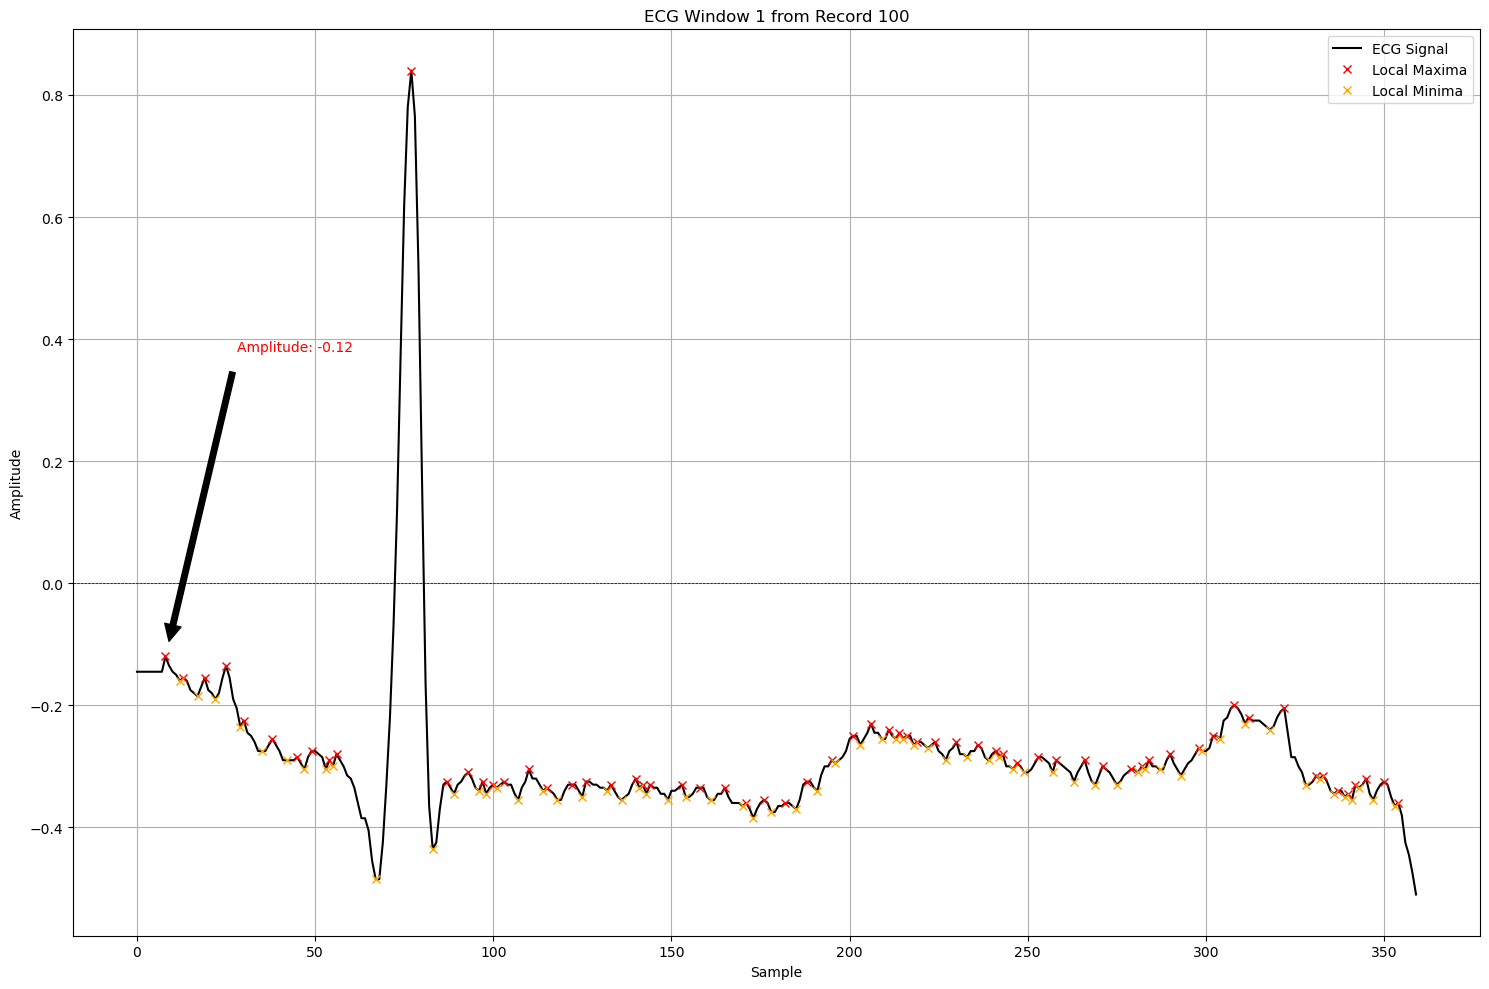

In [105]:
# Function to visualize ECG windows with local maxima and minima
def visualize_ecg_with_peaks(record_id, ecg_segments, num_windows=2):
    colors = ['black']  
    plt.figure(figsize=(15, 10))

    for i, segment in enumerate(ecg_segments[:num_windows]):
        # Detect local maxima and minima
        peaks, _ = find_peaks(segment)  
        valleys, _ = find_peaks(-segment)  

        # Plot the ECG signal
        plt.subplot(num_windows, 1, i + 1)
        plt.plot(segment, color=colors[i % len(colors)], label='ECG Signal')
        
        # Mark local maxima
        plt.plot(peaks, segment[peaks], "x", color='red', label='Local Maxima')
        
        # Mark local minima
        plt.plot(valleys, segment[valleys], "x", color='orange', label='Local Minima')
        
        # Highlight one peak and one valley for demonstration
        if len(peaks) > 0 and len(valleys) > 0:
            peak_index = peaks[0]  
            valley_index = valleys[0]  
            plt.annotate(f'Amplitude: {segment[peak_index]:.2f}', 
                         xy=(peak_index, segment[peak_index]), 
                         xytext=(peak_index + 20, segment[peak_index] + 0.5),
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         fontsize=10, color='red')

        # Set plot titles and labels
        plt.title(f'ECG Window {i+1} from Record {record_id}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.axhline(0, color='black', lw=0.5, ls='--')  
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()
record_id = '100' 
record_path = os.path.join(data_directory, record_id)
ecg_record = wfdb.rdrecord(record_path)
ecg_segments = apply_sliding_window(ecg_record.p_signal[:, 0], win_size=360, overlap_ratio=0.5)


visualize_ecg_with_peaks(record_id, ecg_segments, num_windows=1)


### Exploratory Data Analysis 

In [98]:
# Display summary statistics
summary_statistics = feature_dataframe.describe()
print(summary_statistics)

             Minimum        Maximum         Median       Skewness  \
count  173280.000000  173280.000000  173280.000000  173280.000000   
mean       -1.953666       4.906567      -0.168560       2.390386   
std         1.081239       1.543560       0.137032       1.818129   
min        -8.997134       0.455276      -0.699011      -5.814711   
25%        -2.853328       3.912475      -0.255042       1.263507   
50%        -1.591563       4.946650      -0.183279       2.537941   
75%        -1.034759       5.971935      -0.101433       3.863529   
max        -0.308433      12.552721       0.639323       8.970400   

            Kurtosis       Avg_Peak     Avg_Valley      Amplitude  \
count  173280.000000  173280.000000  173280.000000  173280.000000   
mean       11.560646       3.248289      -1.382728       6.803110   
std         9.140867       1.267458       0.764266       1.509832   
min        -1.772134      -1.086205      -5.705245       0.326144   
25%         4.171268       2.3962

####  1.Distribution of Rythm Label

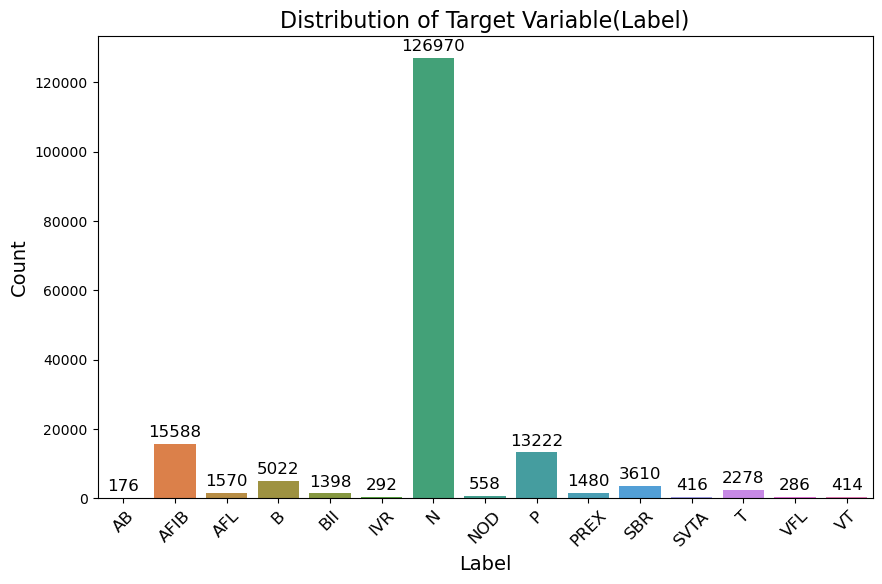

In [62]:
# Visualize the distribution of the target variable 'Label' with a different color palette
plt.figure(figsize=(10, 6))  # Set figure size for better readability

# Plot count plot for the target variable with a different color palette
sns.countplot(x='Label', data=feature_dataframe, palette='husl')  # Change 'pastel' to any other palette you like

# Add count values on top of each bar for clarity
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')

# Set title, labels, and legend for clarity
plt.title('Distribution of Target Variable(Label)', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability

plt.show()


#### 2.Feature Correlation Analysis

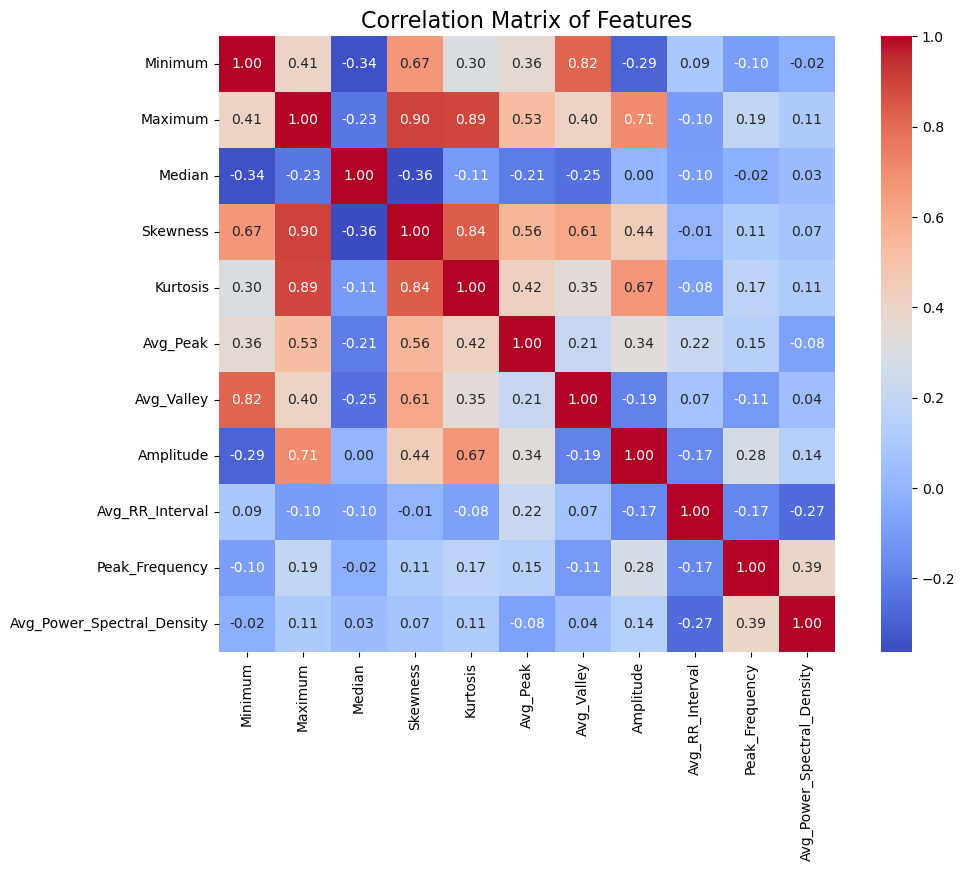

In [63]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = feature_dataframe.drop(columns=['Label', 'HeartRate']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()


#### 3.Univariate Analysis of Numerical Features

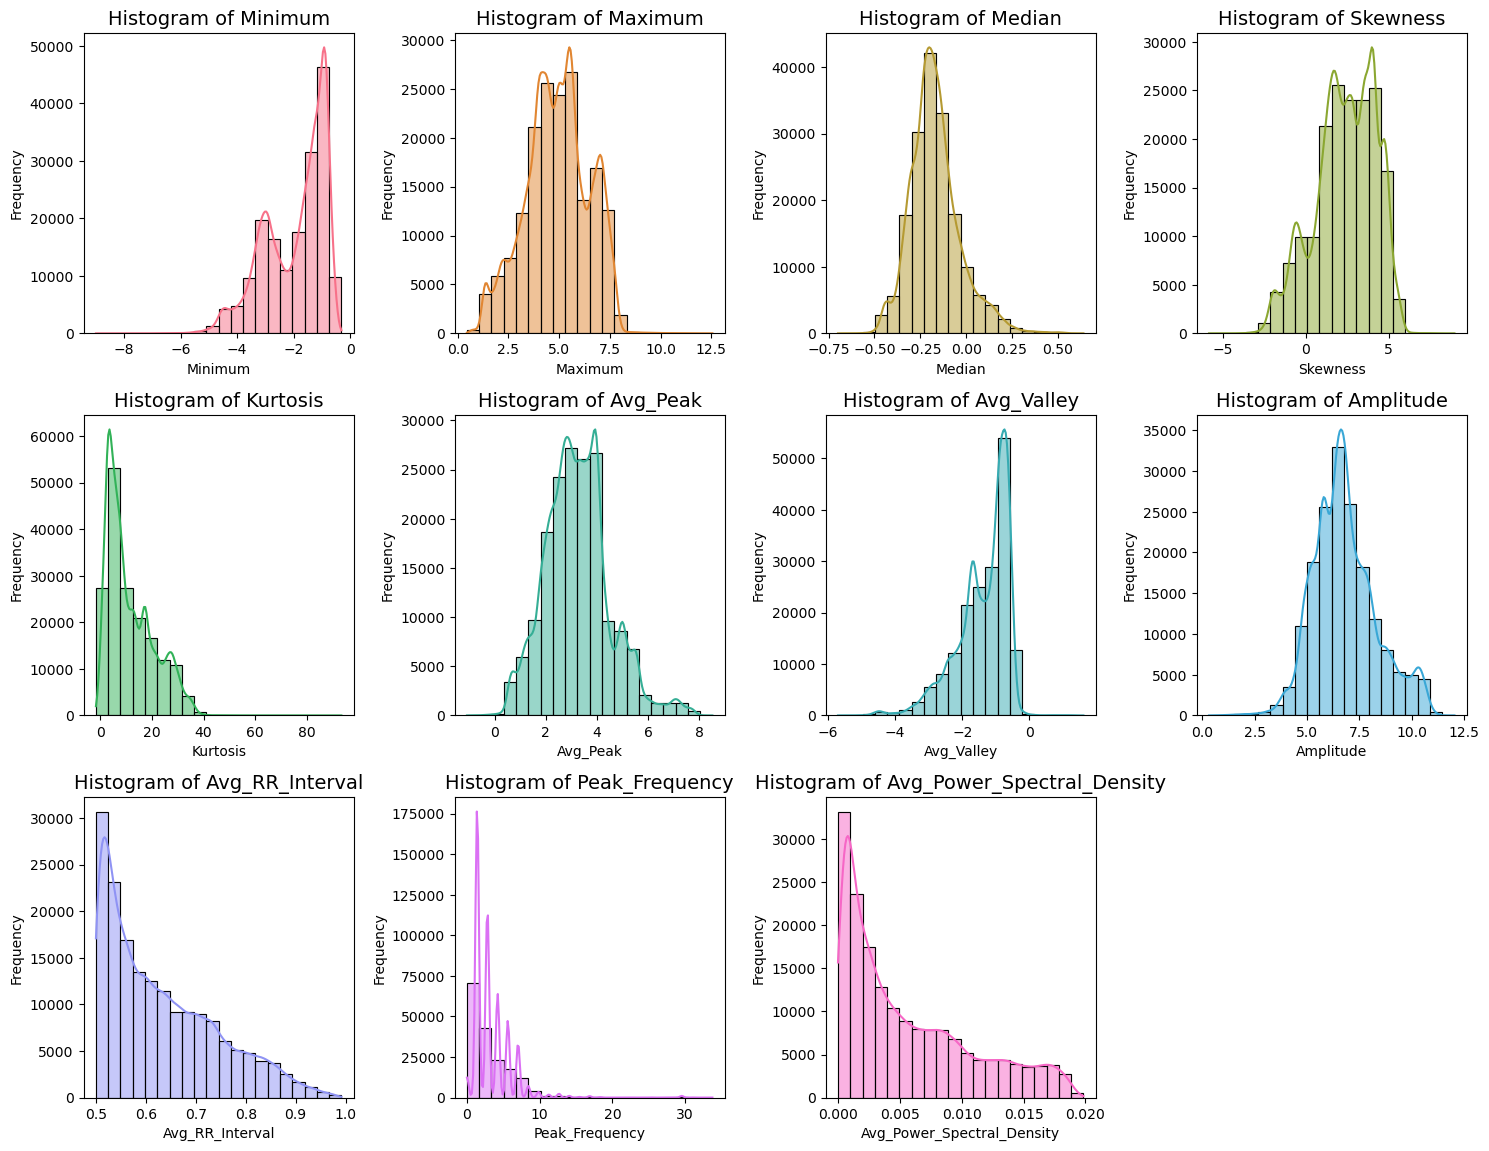

In [64]:
# Define a list of colors for the histograms
colors = sns.color_palette("husl", len(feature_dataframe.drop(columns=['Label', 'HeartRate']).columns))

# Univariate Analysis - Histograms
plt.figure(figsize=(15, 15))
for i, column in enumerate(feature_dataframe.drop(columns=['Label', 'HeartRate']).columns):
    plt.subplot(4, 4, i + 1)  # Adjust the number of rows/columns based on your features
    sns.histplot(feature_dataframe[column], bins=20, kde=True, color=colors[i])
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#### Label Encoding for Categorical Variables

In [65]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Check if the 'Label' column exists and is of type 'category' before encoding
if 'Label' in feature_dataframe.columns:
    # Perform label encoding
    feature_dataframe['Label'] = label_encoder.fit_transform(feature_dataframe['Label'])
    
    # Create a mapping of original labels to their encoded values
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    
    print("\n'Label' column has been label encoded.")
    print("\nLabel Encoding Mapping:")
    for original_label, encoded_value in label_mapping.items():
        print(f"{original_label} -> {encoded_value}")


print("\nUpdated DataFrame:")
print(feature_dataframe.head())



'Label' column has been label encoded.

Label Encoding Mapping:
AB -> 0
AFIB -> 1
AFL -> 2
B -> 3
BII -> 4
IVR -> 5
N -> 6
NOD -> 7
P -> 8
PREX -> 9
SBR -> 10
SVTA -> 11
T -> 12
VFL -> 13
VT -> 14

Updated DataFrame:
    Minimum   Maximum    Median  Skewness   Kurtosis  Avg_Peak  Avg_Valley  \
0 -1.824008  7.434238  0.007341  4.548722  28.048619  4.163973   -0.959397   
1 -1.209420  7.427447 -0.076292  5.273549  31.763370  7.427447   -1.209420   
2 -1.111960  5.604865 -0.211875  3.984114  16.596939  5.473948   -0.961328   
3 -1.562353  7.834253 -0.128077  5.491076  35.829137  4.166451   -0.901496   
4 -1.863916  7.714972 -0.153419  5.278437  34.204335  3.694793   -1.207813   

   Amplitude  HeartRate  Avg_RR_Interval  Peak_Frequency  \
0   9.258246      120.0         0.644444         5.62500   
1   8.636867       60.0         0.644444         5.62500   
2   6.716825      120.0         0.811111         1.40625   
3   9.396606      120.0         0.652778         7.03125   
4   9.578888 

#### 4.Comparative Analysis of Numerical Features with Rythm Label

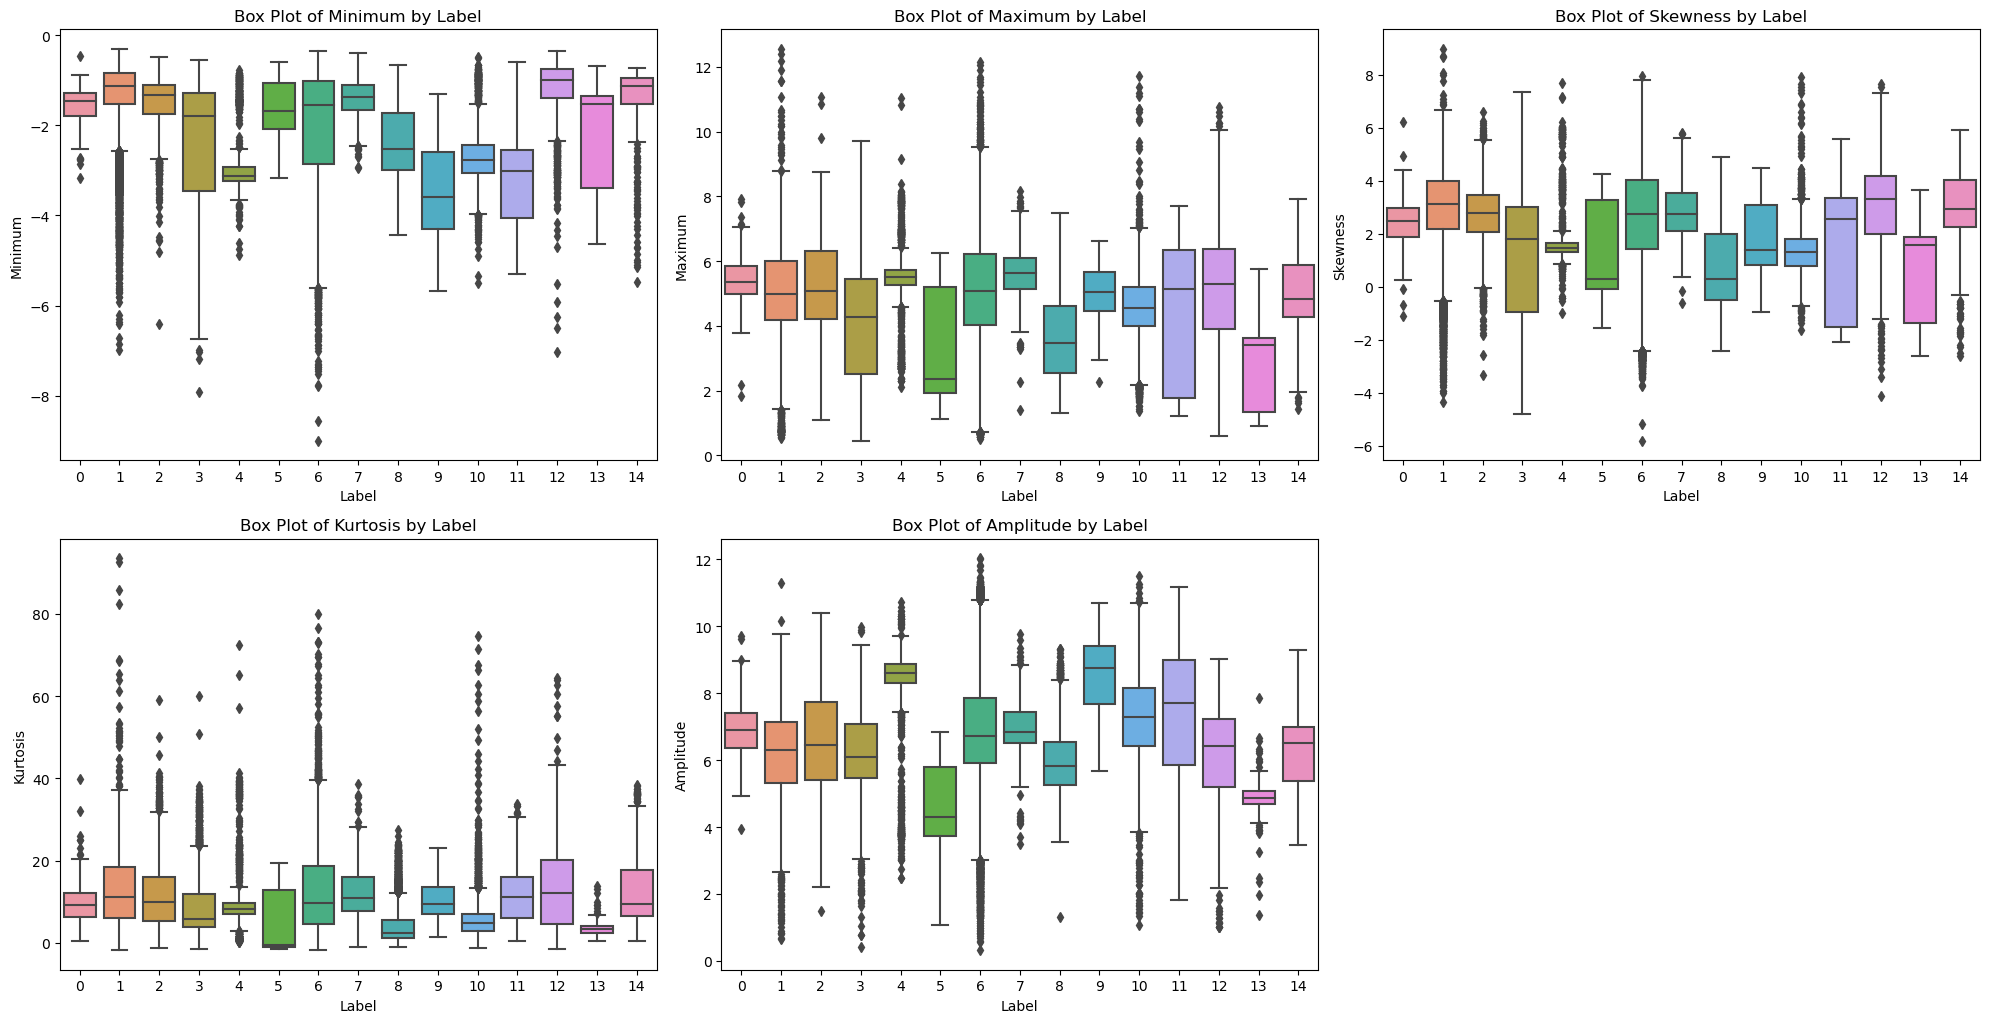

In [66]:
categorical_var = 'Label'

numerical_features = ['Minimum', 'Maximum', 'Skewness', 'Kurtosis', 'Amplitude']

plt.figure(figsize=(20, 15))

for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=categorical_var, y=feature, data=feature_dataframe)
    plt.title(f'Box Plot of {feature} by {categorical_var}')

plt.tight_layout()
plt.show()



In [67]:
# Get the total number of unique rhythm labels and their counts
class_counts = feature_dataframe['Label'].value_counts()
total_classes = len(class_counts)

# Display the total number of classes and their counts
print(f"Total number of rhythm classes: {total_classes}")
print("\nClass counts:\n", class_counts)


Total number of rhythm classes: 15

Class counts:
 Label
6     126970
1      15588
8      13222
3       5022
10      3610
12      2278
2       1570
9       1480
4       1398
7        558
11       416
14       414
5        292
13       286
0        176
Name: count, dtype: int64


### Data Splitting Using Stratified Random Sampling

Shape of Training Features (X_train): (121296, 12)
Shape of Training Labels (y_train): (121296,)
Shape of Testing Features (X_test): (51984, 12)
Shape of Testing Labels (y_test): (51984,)


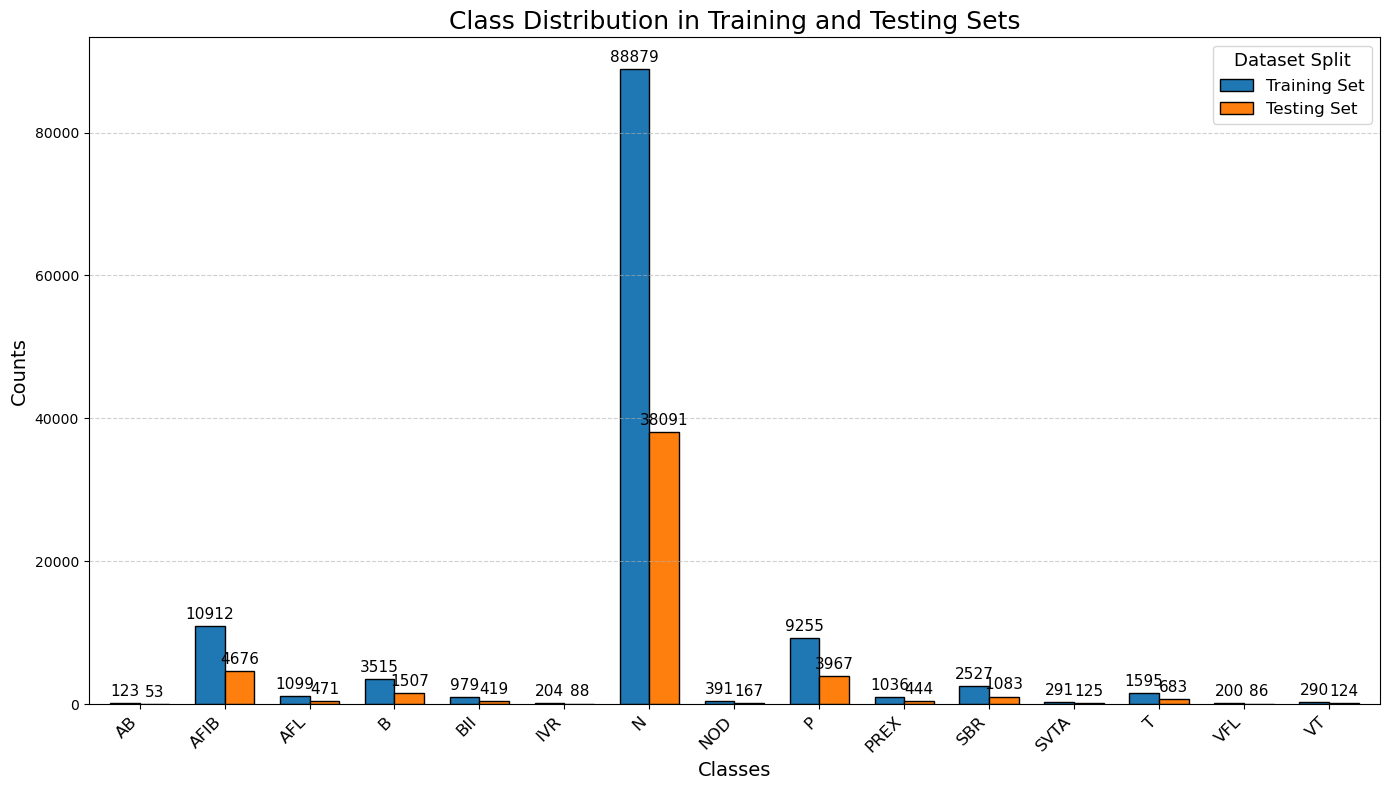

In [68]:
# Data Partitioning using stratified sampling (70% training, 30% testing)
X = feature_dataframe.drop(columns=['Label'])
y = feature_dataframe['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
train_class_counts = y_train.value_counts().sort_index()
test_class_counts = y_test.value_counts().sort_index()
class_counts_df = pd.DataFrame({
    'Training Set': train_class_counts,
    'Testing Set': test_class_counts
})
# Display the shape of the training and testing sets
print("Shape of Training Features (X_train):", X_train.shape)
print("Shape of Training Labels (y_train):", y_train.shape)
print("Shape of Testing Features (X_test):", X_test.shape)
print("Shape of Testing Labels (y_test):", y_test.shape)

class_names = ["AB", "AFIB", "AFL", "B", "BII", "IVR", "N", "NOD", "P", "PREX", "SBR", "SVTA", "T", "VFL", "VT"]

plt.figure(figsize=(14, 8))
ax = class_counts_df.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], edgecolor='black', width=0.7, ax=plt.gca())

plt.title('Class Distribution in Training and Testing Sets', fontsize=18)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.legend(title='Dataset Split', fontsize=12, title_fontsize=13)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=11, padding=3)

plt.tight_layout()

plt.show()


### Model Building And Performance Evaluation

### 1.Random Forest Classifier: Accuracy and Performance Metrics

In [82]:
# Instantiate and train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Display metrics in a table
metrics_rf = [
    ["Metric", "Random Forest"],
    ["Accuracy", accuracy_rf],
    ["Precision", precision_rf],
    ["Recall", recall_rf],
    ["F1 Score", f1_rf]
]
print(tabulate(metrics_rf, headers="firstrow", tablefmt="grid"))

class_names = ["AB", "AFIB", "AFL", "B", "BII", "IVR", "N", "NOD", "P", "PREX", "SBR", "SVTA", "T", "VFL", "VT"]
confusion_rf_df = pd.DataFrame(conf_matrix_rf, index=class_names, columns=class_names)
print("\nConfusion Matrix for Random Forest:")
print(tabulate(confusion_rf_df, headers='keys', tablefmt='grid'))


+-----------+-----------------+
| Metric    |   Random Forest |
+===========+=================+
| Accuracy  |        0.857552 |
+-----------+-----------------+
| Precision |        0.839348 |
+-----------+-----------------+
| Recall    |        0.857552 |
+-----------+-----------------+
| F1 Score  |        0.833231 |
+-----------+-----------------+

Confusion Matrix for Random Forest:
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+-------+------+
|      |   AB |   AFIB |   AFL |   B |   BII |   IVR |     N |   NOD |    P |   PREX |   SBR |   SVTA |   T |   VFL |   VT |
+======+======+========+=======+=====+=======+=======+=======+=======+======+========+=======+========+=====+=======+======+
| AB   |    0 |      0 |     1 |   1 |     0 |     0 |    48 |     3 |    0 |      0 |     0 |      0 |   0 |     0 |    0 |
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+--

### 2.Gradient Boosting Classifier: Accuracy and Performance Metrics

In [75]:

gb_model = GradientBoostingClassifier(n_estimators=10, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

# Calculate metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted', zero_division=0)
recall_gb = recall_score(y_test, y_pred_gb, average='weighted', zero_division=0)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Display metrics in a table
metrics_gb = [
    ["Metric", "Gradient Boosting"],
    ["Accuracy", accuracy_gb],
    ["Precision", precision_gb],
    ["Recall", recall_gb],
    ["F1 Score", f1_gb]
]
print(tabulate(metrics_gb, headers="firstrow", tablefmt="grid"))

class_names = ["AB", "AFIB", "AFL", "B", "BII", "IVR", "N", "NOD", "P", "PREX", "SBR", "SVTA", "T", "VFL", "VT"]
confusion_gb = pd.DataFrame(conf_matrix_gb, index=class_names, columns=class_names)
print("\nConfusion Matrix for Gradient Boosting:")
print(tabulate(confusion_gb, headers='keys', tablefmt='grid'))



+-----------+---------------------+
| Metric    |   Gradient Boosting |
+===========+=====================+
| Accuracy  |            0.75631  |
+-----------+---------------------+
| Precision |            0.760738 |
+-----------+---------------------+
| Recall    |            0.75631  |
+-----------+---------------------+
| F1 Score  |            0.676172 |
+-----------+---------------------+

Confusion Matrix for Gradient Boosting:
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+-------+------+
|      |   AB |   AFIB |   AFL |   B |   BII |   IVR |     N |   NOD |    P |   PREX |   SBR |   SVTA |   T |   VFL |   VT |
+======+======+========+=======+=====+=======+=======+=======+=======+======+========+=======+========+=====+=======+======+
| AB   |    0 |      0 |     0 |   0 |     1 |     0 |    52 |     0 |    0 |      0 |     0 |      0 |   0 |     0 |    0 |
+------+------+--------+-------+-----+-------+-------+-------+-

### 3.XGBoost Classifier: Accuracy and Performance Metrics

In [77]:
# Instantiate and train XGBoost Classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Display metrics in a table
metrics_xgb = [
    ["Metric", "XGBoost"],
    ["Accuracy", accuracy_xgb],
    ["Precision", precision_xgb],
    ["Recall", recall_xgb],
    ["F1 Score", f1_xgb]
]
print(tabulate(metrics_xgb, headers="firstrow", tablefmt="grid"))

# Display confusion matrix with original class names
class_names = ["AB", "AFIB", "AFL", "B", "BII", "IVR", "N", "NOD", "P", "PREX", "SBR", "SVTA", "T", "VFL", "VT"]
confusion_xgb = pd.DataFrame(conf_matrix_xgb, index=class_names, columns=class_names)
print("\nConfusion Matrix for XGBoost:")
print(tabulate(confusion_xgb, headers='keys', tablefmt='grid'))



+-----------+-----------+
| Metric    |   XGBoost |
+===========+===========+
| Accuracy  |  0.850685 |
+-----------+-----------+
| Precision |  0.82818  |
+-----------+-----------+
| Recall    |  0.850685 |
+-----------+-----------+
| F1 Score  |  0.829091 |
+-----------+-----------+

Confusion Matrix for XGBoost:
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+-------+------+
|      |   AB |   AFIB |   AFL |   B |   BII |   IVR |     N |   NOD |    P |   PREX |   SBR |   SVTA |   T |   VFL |   VT |
+======+======+========+=======+=====+=======+=======+=======+=======+======+========+=======+========+=====+=======+======+
| AB   |    1 |      0 |     4 |   0 |     0 |     0 |    40 |     6 |    2 |      0 |     0 |      0 |   0 |     0 |    0 |
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+-------+------+
| AFIB |    0 |   2675 |    12 |   9 |     0 |     1 |  18

### Comparative Analysis of Model Performance Metrics

In [83]:
# Create a comparison DataFrame
comparison_metrics = {
    "Model": ["Random Forest", "Gradient Boosting", "XGBoost"],
    "Accuracy": [accuracy_rf, accuracy_gb, accuracy_xgb],
    "Precision": [precision_rf, precision_gb, precision_xgb],
    "Recall": [recall_rf, recall_gb, recall_xgb],
    "F1 Score": [f1_rf, f1_gb, f1_xgb]
}

comparison_df = pd.DataFrame(comparison_metrics)

# Print the comparison table
print("\nModel Comparison Metrics:")
print(tabulate(comparison_df, headers="keys", tablefmt="grid"))


Model Comparison Metrics:
+----+-------------------+------------+-------------+----------+------------+
|    | Model             |   Accuracy |   Precision |   Recall |   F1 Score |
+====+===================+============+=============+==========+============+
|  0 | Random Forest     |   0.857552 |    0.839348 | 0.857552 |   0.833231 |
+----+-------------------+------------+-------------+----------+------------+
|  1 | Gradient Boosting |   0.75631  |    0.760738 | 0.75631  |   0.676172 |
+----+-------------------+------------+-------------+----------+------------+
|  2 | XGBoost           |   0.850685 |    0.82818  | 0.850685 |   0.829091 |
+----+-------------------+------------+-------------+----------+------------+


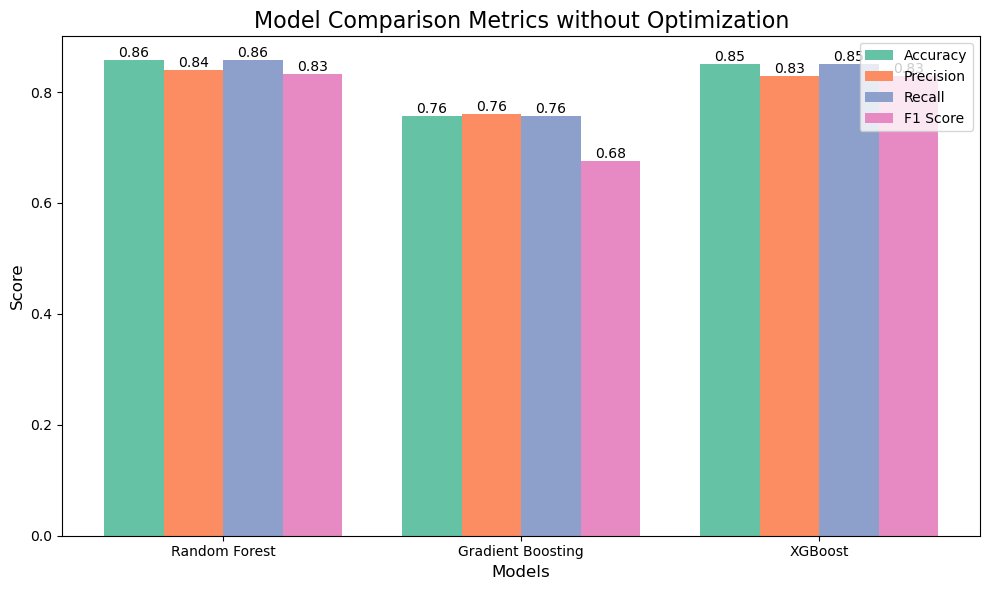

In [84]:
palette = sns.color_palette("Set2")
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(len(comparison_df))

bars1 = ax.bar(index, comparison_df["Accuracy"], bar_width, label='Accuracy', color=palette[0])
bars2 = ax.bar([i + bar_width for i in index], comparison_df["Precision"], bar_width, label='Precision', color=palette[1])
bars3 = ax.bar([i + 2 * bar_width for i in index], comparison_df["Recall"], bar_width, label='Recall', color=palette[2])
bars4 = ax.bar([i + 3 * bar_width for i in index], comparison_df["F1 Score"], bar_width, label='F1 Score', color=palette[3])

for bar in bars1 + bars2 + bars3 + bars4:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom', ha='center')  # va: vertical alignment

ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(comparison_df["Model"])

ax.set_title('Model Comparison Metrics without Optimization', fontsize=16)
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Models', fontsize=12)

ax.legend()

plt.tight_layout()
plt.show()

### Enhanced Model Building and Evaluation through Optimization

### 1.Optimizing Random Forest Classifier: Parameter Tuning and Performance Metrics

In [81]:
# Optimized Random Forest model with GridSearchCV
rf_model = RandomForestClassifier(random_state=42)

# Define a small grid for hyperparameter tuning
param_grid = {
    'n_estimators': [30, 40],       
    'max_depth': [10, 20],           
    'min_samples_split': [5, 10]     
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_rf_model = grid_search.best_estimator_

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Calculate metrics with zero_division to handle undefined precision
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Display metrics in a table
metrics_rf = [
    ["Metric", "Random Forest"],
    ["Accuracy", accuracy_rf],
    ["Precision", precision_rf],
    ["Recall", recall_rf],
    ["F1 Score", f1_rf]
]
print(tabulate(metrics_rf, headers="firstrow", tablefmt="grid"))

# Display confusion matrix with original class names
class_names = ["AB", "AFIB", "AFL", "B", "BII", "IVR", "N", "NOD", "P", "PREX", "SBR", "SVTA", "T", "VFL", "VT"]
confusion_rf_df = pd.DataFrame(conf_matrix_rf, index=class_names, columns=class_names)
print("\nConfusion Matrix for Optimized Random Forest:")
print(tabulate(confusion_rf_df, headers='keys', tablefmt='grid'))

# Display best parameters
print("\nBest Parameters:", grid_search.best_params_)



Fitting 3 folds for each of 8 candidates, totalling 24 fits
+-----------+-----------------+
| Metric    |   Random Forest |
+===========+=================+
| Accuracy  |        0.851627 |
+-----------+-----------------+
| Precision |        0.833329 |
+-----------+-----------------+
| Recall    |        0.851627 |
+-----------+-----------------+
| F1 Score  |        0.82542  |
+-----------+-----------------+

Confusion Matrix for Optimized Random Forest:
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+-------+------+
|      |   AB |   AFIB |   AFL |   B |   BII |   IVR |     N |   NOD |    P |   PREX |   SBR |   SVTA |   T |   VFL |   VT |
+======+======+========+=======+=====+=======+=======+=======+=======+======+========+=======+========+=====+=======+======+
| AB   |    0 |      0 |     1 |   0 |     0 |     0 |    50 |     2 |    0 |      0 |     0 |      0 |   0 |     0 |    0 |
+------+------+--------+-------+-----+---

### 2.Optimizing Gradient Boosting Classifier: Parameter Tuning and Performance Metrics

In [85]:
# Instantiate Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Define a small grid for hyperparameter tuning
param_grid = {
    'n_estimators': [20, 30],        
    'learning_rate': [0.1, 0.05],     
    'max_depth': [3, 5]               
}

grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_gb_model = grid_search.best_estimator_


y_pred_gb = best_gb_model.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted', zero_division=0)
recall_gb = recall_score(y_test, y_pred_gb, average='weighted', zero_division=0)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted', zero_division=0)


conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

metrics_gb = [
    ["Metric", "Gradient Boosting"],
    ["Accuracy", accuracy_gb],
    ["Precision", precision_gb],
    ["Recall", recall_gb],
    ["F1 Score", f1_gb]
]
print(tabulate(metrics_gb, headers="firstrow", tablefmt="grid"))

class_names = ["AB", "AFIB", "AFL", "B", "BII", "IVR", "N", "NOD", "P", "PREX", "SBR", "SVTA", "T", "VFL", "VT"]
confusion_gb_df = pd.DataFrame(conf_matrix_gb, index=class_names, columns=class_names)
print("\nConfusion Matrix for Optimized Gradient Boosting:")
print(tabulate(confusion_gb_df, headers='keys', tablefmt='grid'))

# Display best parameters
print("\nBest Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
+-----------+---------------------+
| Metric    |   Gradient Boosting |
+===========+=====================+
| Accuracy  |            0.806941 |
+-----------+---------------------+
| Precision |            0.780681 |
+-----------+---------------------+
| Recall    |            0.806941 |
+-----------+---------------------+
| F1 Score  |            0.775372 |
+-----------+---------------------+

Confusion Matrix for Optimized Gradient Boosting:
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+-------+------+
|      |   AB |   AFIB |   AFL |   B |   BII |   IVR |     N |   NOD |    P |   PREX |   SBR |   SVTA |   T |   VFL |   VT |
+======+======+========+=======+=====+=======+=======+=======+=======+======+========+=======+========+=====+=======+======+
| AB   |    0 |      0 |     1 |   0 |     0 |     0 |    48 |     4 |    0 |      0 |     0 |      0 |   0 |     0 | 

### 3.Optimizing XGBoost Classifier: Parameter Tuning and Performance Metrics

In [91]:
# Instantiate XGBoost Classifier 
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Define a refined grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],             
    'learning_rate': [0.1, 0.2],     
    'max_depth': [7,8],                 
     'subsample': [0.9, 1.0],                
    'colsample_bytree': [0.8, 1.0],         
    'gamma': [0.2, 0.3]                                 
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate metrics with zero_division to handle undefined precision
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Display metrics in a table
metrics_xgb = [
    ["Metric", "XGBoost"],
    ["Accuracy", accuracy_xgb],
    ["Precision", precision_xgb],
    ["Recall", recall_xgb],
    ["F1 Score", f1_xgb]
]
print(tabulate(metrics_xgb, headers="firstrow", tablefmt="grid"))

class_names = ["AB", "AFIB", "AFL", "B", "BII", "IVR", "N", "NOD", "P", "PREX", "SBR", "SVTA", "T", "VFL", "VT"]
confusion_xgb_df = pd.DataFrame(conf_matrix_xgb, index=class_names, columns=class_names)
print("\nConfusion Matrix for Optimized XGBoost:")
print(tabulate(confusion_xgb_df, headers='keys', tablefmt='grid'))

# Display best parameters
print("\nBest Parameters:", grid_search.best_params_)




Fitting 3 folds for each of 64 candidates, totalling 192 fits
+-----------+-----------+
| Metric    |   XGBoost |
+===========+===========+
| Accuracy  |  0.85838  |
+-----------+-----------+
| Precision |  0.839186 |
+-----------+-----------+
| Recall    |  0.85838  |
+-----------+-----------+
| F1 Score  |  0.838064 |
+-----------+-----------+

Confusion Matrix for Optimized XGBoost:
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+-------+------+
|      |   AB |   AFIB |   AFL |   B |   BII |   IVR |     N |   NOD |    P |   PREX |   SBR |   SVTA |   T |   VFL |   VT |
+======+======+========+=======+=====+=======+=======+=======+=======+======+========+=======+========+=====+=======+======+
| AB   |    0 |      0 |     2 |   0 |     0 |     0 |    43 |     7 |    1 |      0 |     0 |      0 |   0 |     0 |    0 |
+------+------+--------+-------+-----+-------+-------+-------+-------+------+--------+-------+--------+-----+--

### Comparative Analysis of Optimized Model Performance Metrics


Comparison of Optimized Models:
+-----------+-----------------+---------------------+-----------+
| Metric    |   Random Forest |   Gradient Boosting |   XGBoost |
+===========+=================+=====================+===========+
| Accuracy  |        0.857552 |            0.806941 |  0.85838  |
+-----------+-----------------+---------------------+-----------+
| Precision |        0.839348 |            0.780681 |  0.839186 |
+-----------+-----------------+---------------------+-----------+
| Recall    |        0.857552 |            0.806941 |  0.85838  |
+-----------+-----------------+---------------------+-----------+
| F1 Score  |        0.833231 |            0.775372 |  0.838064 |
+-----------+-----------------+---------------------+-----------+


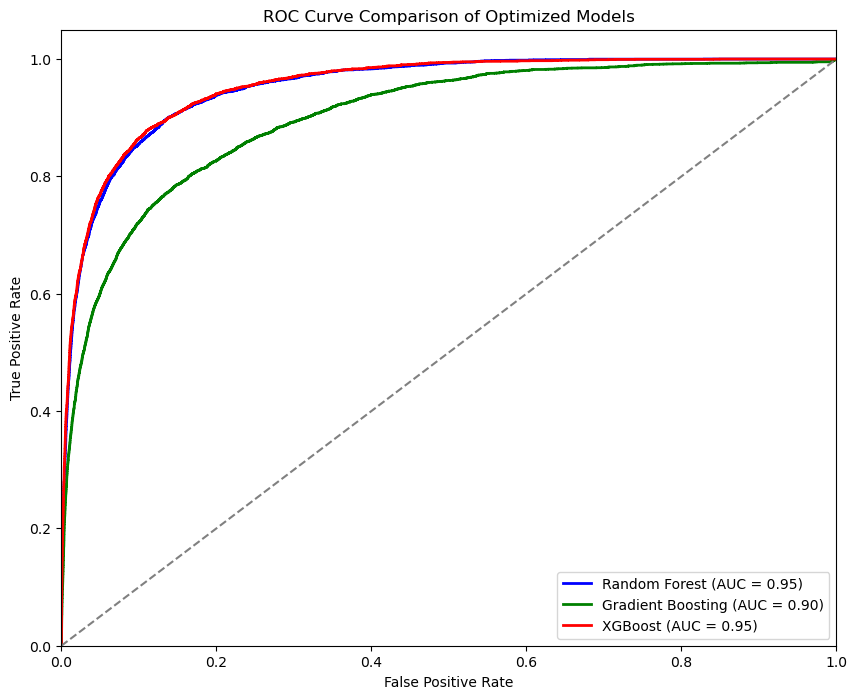

In [99]:
# Comparison table with metrics for all models
metrics_comparison = [
    ["Metric", "Random Forest", "Gradient Boosting", "XGBoost"],
    ["Accuracy", accuracy_rf, accuracy_gb, accuracy_xgb],
    ["Precision", precision_rf, precision_gb, precision_xgb],
    ["Recall", recall_rf, recall_gb, recall_xgb],
    ["F1 Score", f1_rf, f1_gb, f1_xgb]
]
print("\nComparison of Optimized Models:")
print(tabulate(metrics_comparison, headers="firstrow", tablefmt="grid"))

# ROC Curve and AUC Plot
plt.figure(figsize=(10, 8))

# Dictionary to store model ROC AUC for legend
model_metrics = {
    "Random Forest": (best_rf_model, 'blue'),
    "Gradient Boosting": (best_gb_model, 'green'),
    "XGBoost": (best_xgb_model, 'red')
}

# Calculate ROC curves and plot
for model_name, (model, color) in model_metrics.items():
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)  # Adjust pos_label if necessary
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Optimized Models')
plt.legend(loc="lower right")
plt.show()


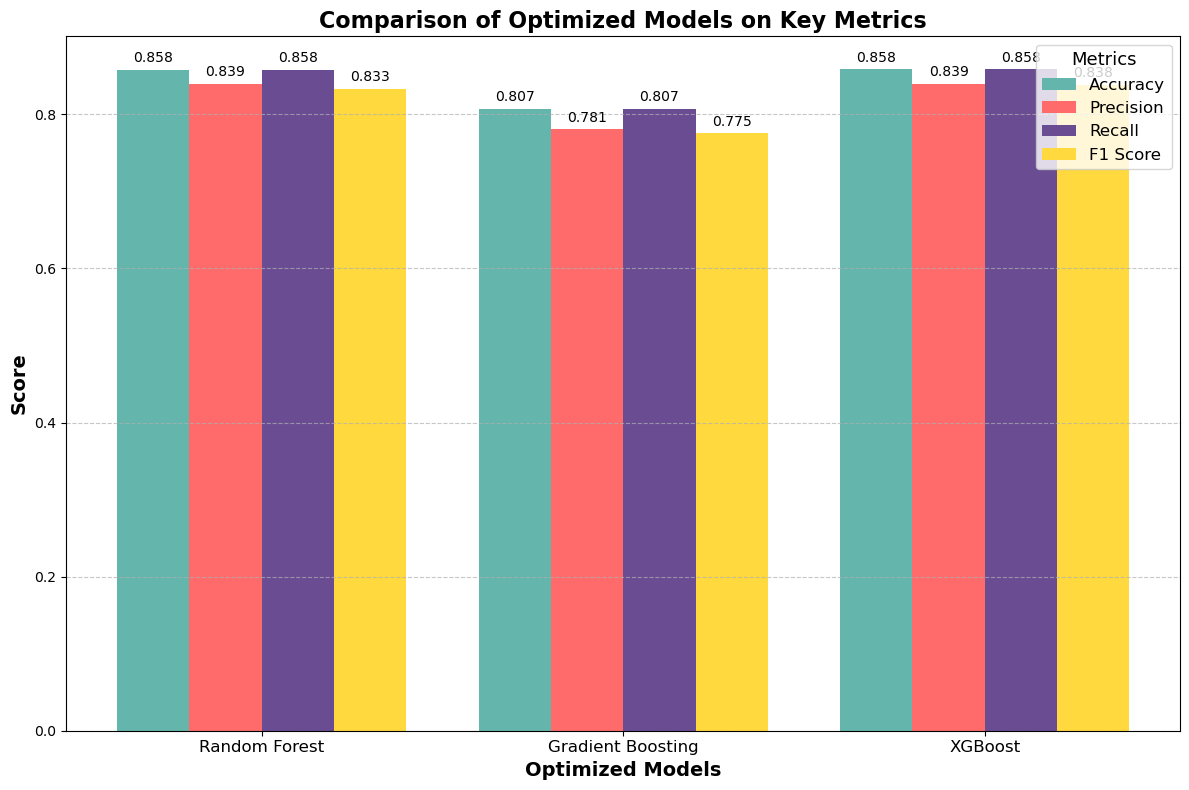

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Define models and their respective metrics
models = ["Random Forest", "Gradient Boosting", "XGBoost"]
accuracy = [accuracy_rf, accuracy_gb, accuracy_xgb]
precision = [precision_rf, precision_gb, precision_xgb]
recall = [recall_rf, recall_gb, recall_xgb]
f1_score = [f1_rf, f1_gb, f1_xgb]

# Define a fresh pastel color palette and bar width
colors = ["#64b6ac", "#ff6b6b", "#6a4c93", "#ffd93d"]  # Teal, Coral, Lavender, Mustard
bar_width = 0.2

# Set x locations for each model
x = np.arange(len(models))


plt.figure(figsize=(12, 8))
plt.bar(x - bar_width*1.5, accuracy, width=bar_width, color=colors[0], label="Accuracy")
plt.bar(x - bar_width/2, precision, width=bar_width, color=colors[1], label="Precision")
plt.bar(x + bar_width/2, recall, width=bar_width, color=colors[2], label="Recall")
plt.bar(x + bar_width*1.5, f1_score, width=bar_width, color=colors[3], label="F1 Score")

# Add labels and title
plt.xlabel("Optimized Models", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontsize=14, fontweight='bold')
plt.title("Comparison of Optimized Models on Key Metrics", fontsize=16, fontweight='bold')
plt.xticks(x, models, fontsize=12)


for i in range(len(models)):
    plt.text(x[i] - bar_width*1.5, accuracy[i] + 0.01, f"{accuracy[i]:.3f}", ha="center", color="black", fontsize=10)
    plt.text(x[i] - bar_width/2, precision[i] + 0.01, f"{precision[i]:.3f}", ha="center", color="black", fontsize=10)
    plt.text(x[i] + bar_width/2, recall[i] + 0.01, f"{recall[i]:.3f}", ha="center", color="black", fontsize=10)
    plt.text(x[i] + bar_width*1.5, f1_score[i] + 0.01, f"{f1_score[i]:.3f}", ha="center", color="black", fontsize=10)

# Display legend and grid
plt.legend(title="Metrics", fontsize=12, title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot with tight layout
plt.tight_layout()
plt.show()


### Comparative Analysis and Conclusion of Model Performance: Optimized vs. Non-Optimized Metrics